<div style="text-align: center; background-color: #f2f2f2; padding: 15px;">
  <h1 style="color: #efc039; font-size: 35px;">Casas em California</h1>
</div>

![](https://static.independent.co.uk/2023/06/23/15/iStock-468040530.jpg)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import cv2
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('housing.csv')
print(df.shape)
df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- o conjunto de dados possui alguns valores ausentes na coluna 'total_bedrooms'
- os tipos de coluna estão todos corretos

<div style="text-align: center; background-color: #f2f2f2; padding: 10px;">
  <h1 style="color: #efc039; font-size: 25px;">Pré-processamento de Dados</h1>
</div>

In [4]:
# imputando a média dos campos ausentes de 'total_bedrooms'

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df['total_bedrooms'] = imputer.fit_transform(df.total_bedrooms.values.reshape(-1, 1))

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.870553,419.266592,1.0000,297.0000,438.0000,643.25000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


- verificando os outliers

In [6]:
# criando uma função que faz um boxplot e calcula a quantidade de outliers em uma feature específica

def viewing_outliers(df, feature_name):
    Q1 = np.percentile(df[feature_name], 25)
    Q3 = np.percentile(df[feature_name], 75)
    
    IQR = Q3 - Q1
    
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR

    qtd_up_outliers = np.sum(df[feature_name] > up_limit)
    qtd_low_outliers = np.sum(df[feature_name] < low_limit)
    
    fig, ax = plt.subplots()
    
    sns.boxplot(df[feature_name], orient='h', ax=ax)
    ax.set_title(feature_name, fontsize=14)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel(f'Contém {qtd_up_outliers + qtd_low_outliers} outliers', fontsize=12)
    
    plt.show()

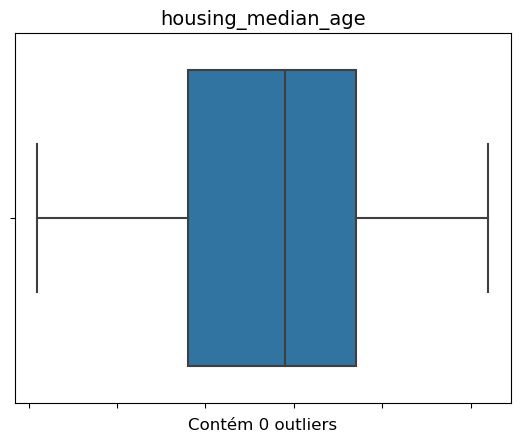

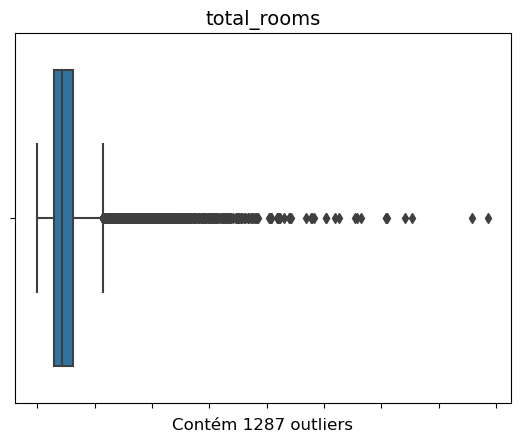

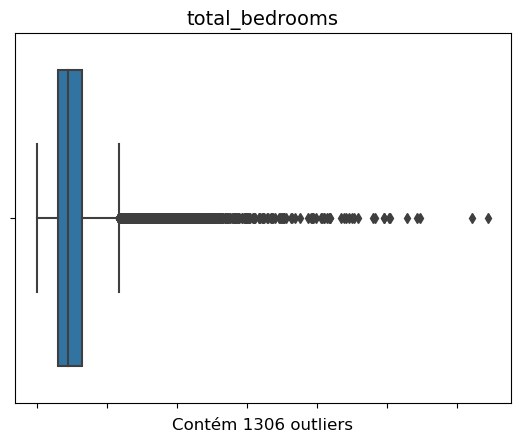

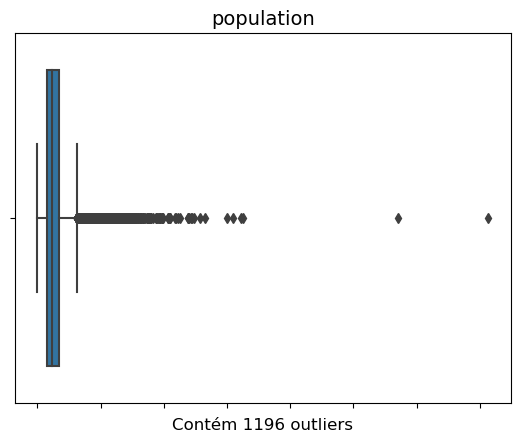

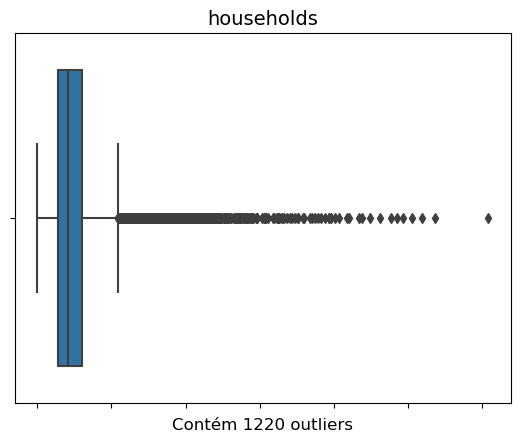

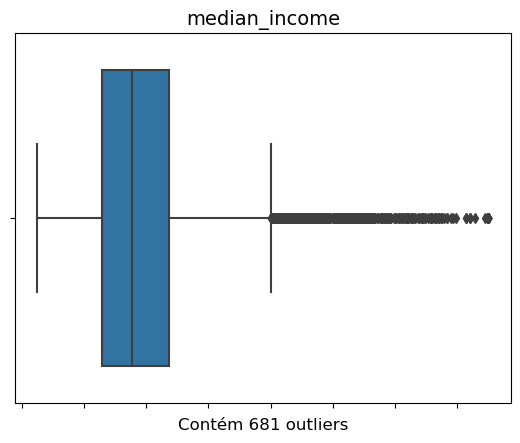

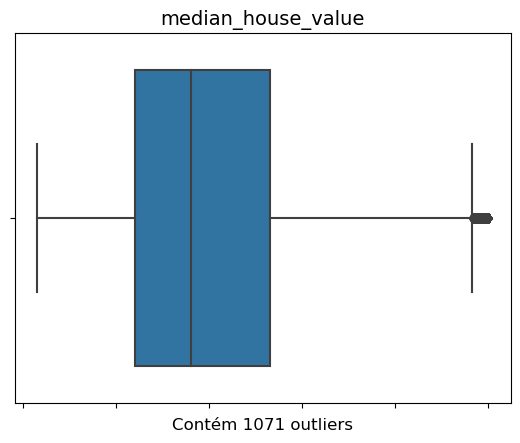

In [7]:
columns_outliers = df.drop(['longitude', 'latitude', 'ocean_proximity'], axis=1)

for col in columns_outliers.columns:
    viewing_outliers(df, col)

In [8]:
# criando uma função que remove os outliers

def remove_outliers(df, feature_name):
    Q1 = np.percentile(df[feature_name], 25)
    Q3 = np.percentile(df[feature_name], 75)
    
    IQR = Q3 - Q1
    
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    df.drop(df.index[(df[feature_name] <= low_limit) | (df[feature_name] >= up_limit)], inplace=True)

In [9]:
remove_outliers(df, 'median_income')

In [10]:
columns_outliers = df.drop(['longitude', 'latitude', 'ocean_proximity'], axis=1)

for col in columns_outliers.columns:
    remove_outliers(df, col)

In [11]:
df.shape

(16788, 10)

<div style="text-align: center; background-color: #f2f2f2; padding: 10px;">
  <h1 style="color: #fabf81; font-size: 25px;">Análise Exploratória dos Dados</h1>
</div>

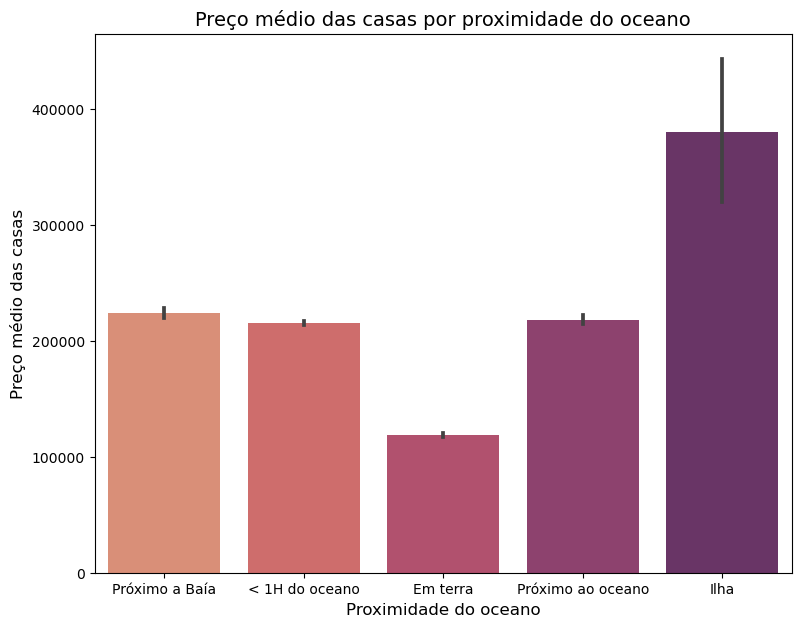

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))

sns.barplot(data=df, x='ocean_proximity', y='median_house_value', ax=ax, palette='flare')

ax.set_title('Preço médio das casas por proximidade do oceano', fontsize=14)
ax.set_xlabel('Proximidade do oceano', fontsize=12)
ax.set_ylabel('Preço médio das casas', fontsize=12)

ax.set_xticklabels(['Próximo a Baía', '< 1H do oceano', 'Em terra', 'Próximo ao oceano', 'Ilha'])

plt.show()

- aparentemente, quanto mais perto a casa está do mar, mais cara ela é
- vamos traçar outro gráfico

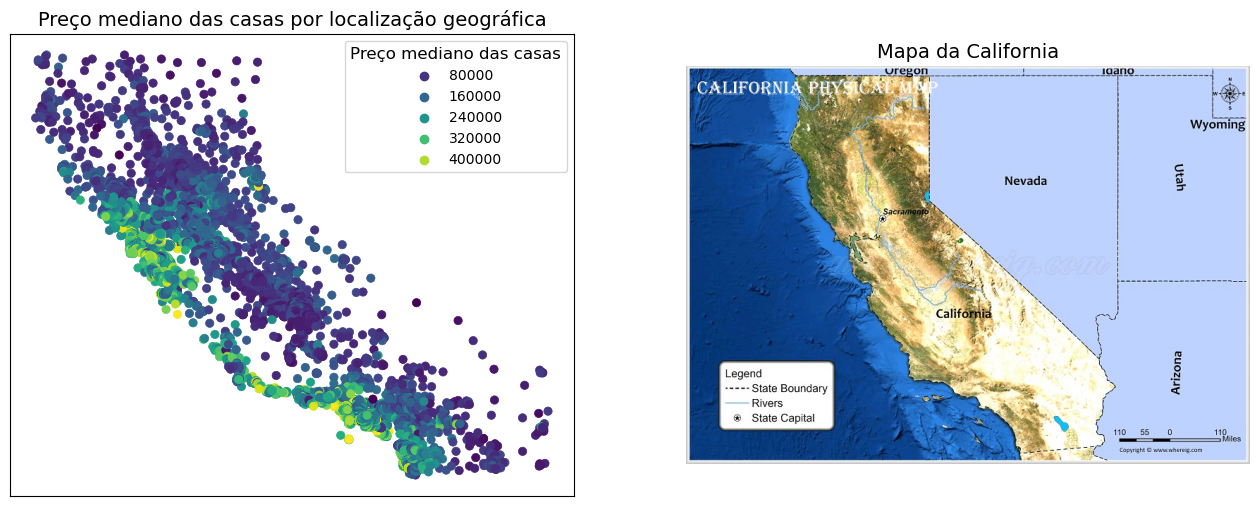

In [13]:
image_url = "https://www.whereig.com/usa/maps/physical/california-physical-map.jpg"

response = requests.get(image_url)
image_data = np.frombuffer(response.content, np.uint8)

image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(16, 6), ncols=2)

sns.scatterplot(data=df, x='longitude', y='latitude',
                hue='median_house_value', palette='viridis', edgecolor=None, ax=ax[0])

ax[1].imshow(image)
ax[1].axis('off')
ax[1].set_title('Mapa da California', fontsize=14)

ax[0].set_title('Preço mediano das casas por localização geográfica', fontsize=14)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_xticks([])
ax[0].set_yticks([])

legend = ax[0].legend()
legend.set_title('Preço mediano das casas', prop={'size': 12})

plt.savefig('california_map.png', transparent=False)

- agora podemos ver mais claramente como a proximidade do oceano se correlaciona com o valor médio da casa

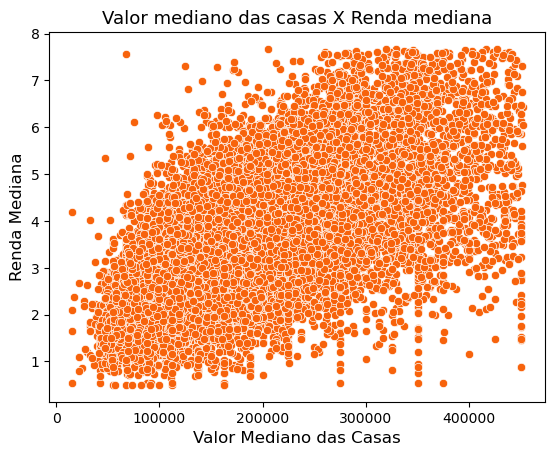

In [14]:
fig, ax = plt.subplots()

sns.scatterplot(data=df, x='median_house_value', y='median_income', ax=ax, color='#f7630c')

ax.set_title('Valor mediano das casas X Renda mediana', fontsize=13)
ax.set_xlabel('Valor Mediano das Casas', fontsize=12)
ax.set_ylabel('Renda Mediana', fontsize=12)

plt.show()

- podemos ver que median_income tem uma correlação positiva alta com median_house_value

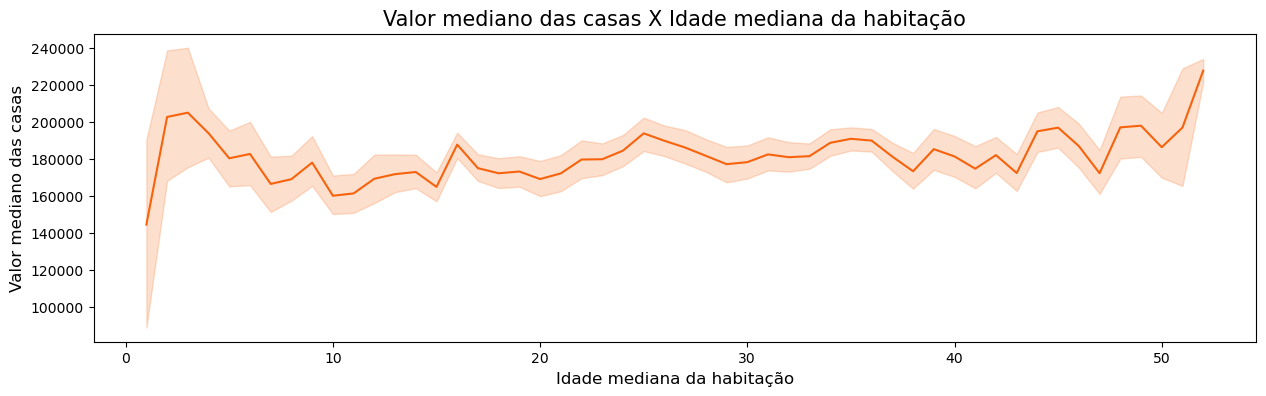

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(data=df, x='housing_median_age', y='median_house_value', color='#f7630c')

ax.set_title('Valor mediano das casas X Idade mediana da habitação', fontsize=15)
ax.set_xlabel('Idade mediana da habitação', fontsize=12)
ax.set_ylabel('Valor mediano das casas', fontsize=12)

plt.show()

- a idade não apresenta uma correlação clara com o valor médio da casa

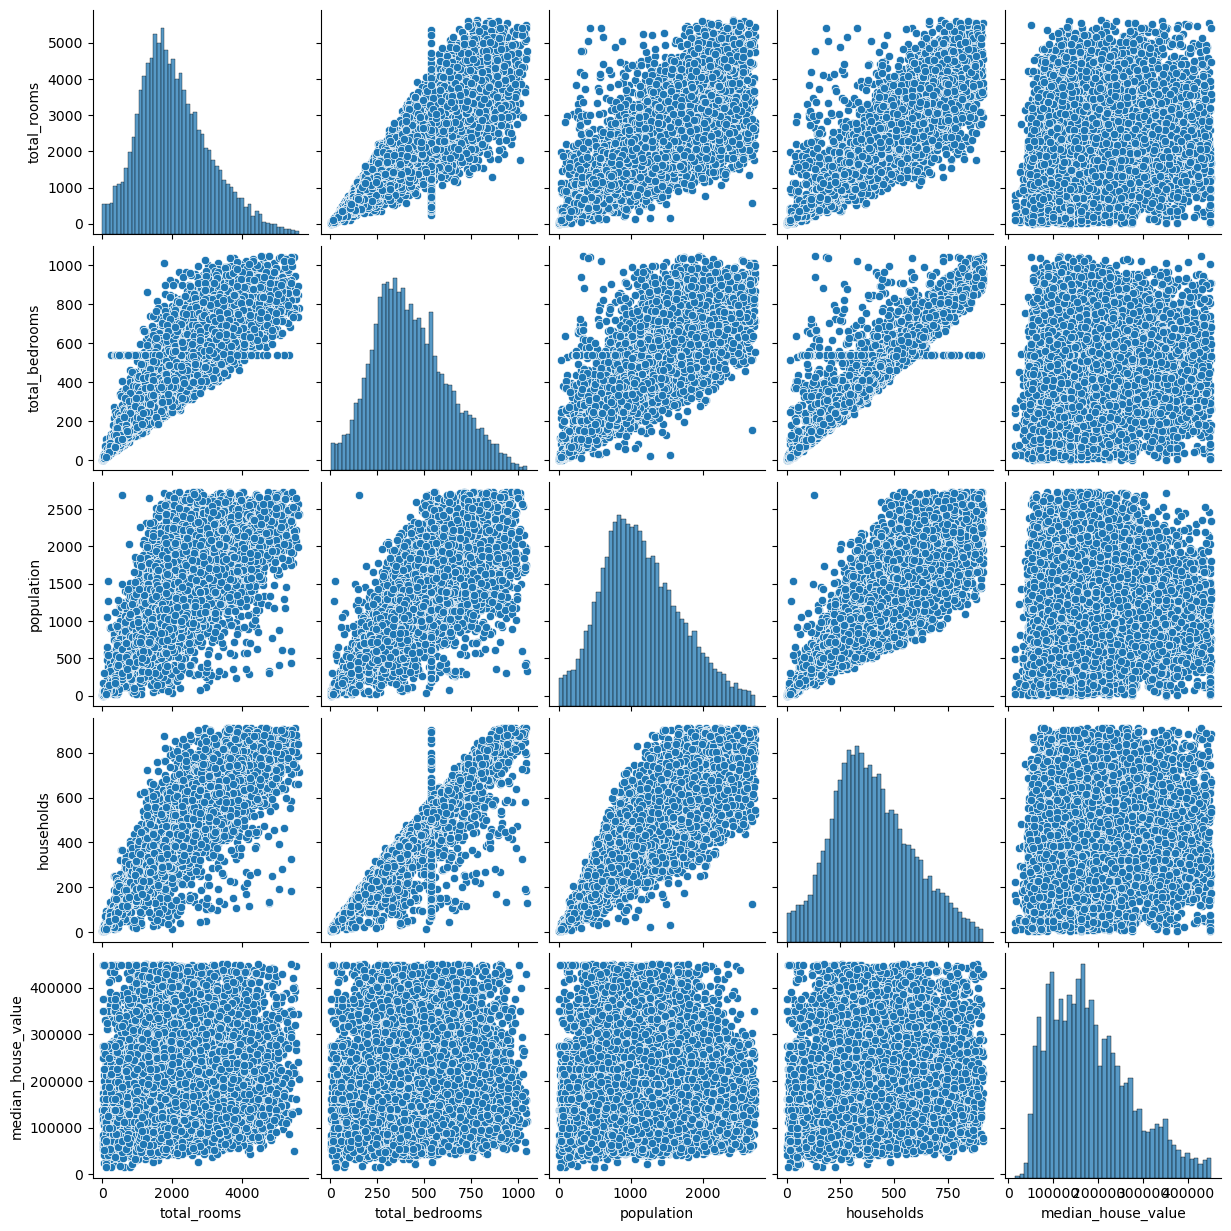

In [16]:
df_other_columns = df[['total_rooms','total_bedrooms','population','households', 'median_house_value']]

sns.pairplot(df_other_columns);

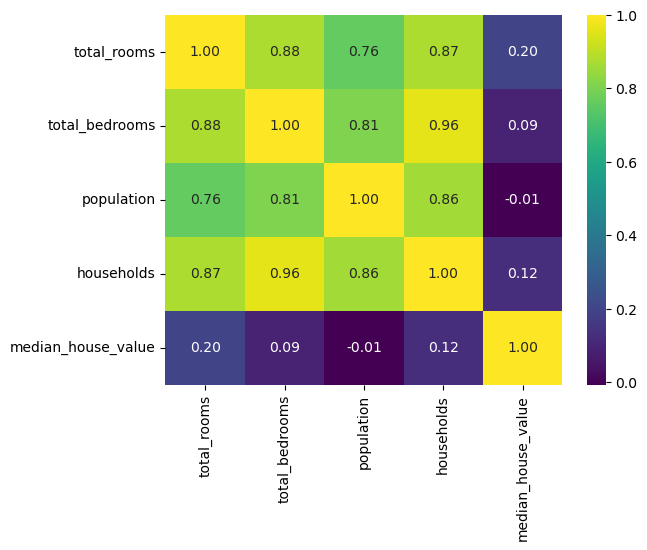

In [17]:
sns.heatmap(data=df_other_columns.corr(), annot=True, cmap='viridis', fmt=".2f");

- todas as colunas restantes têm uma correlação positiva alta entre si, ao contrário da coluna de destino
- essas colunas podem causar uma **alta multicolinearidade**, e atrapalhar alguns modelos de aprendizado de máquina, vamos remover as colunas, com exceção apenas da coluna 'total_rooms', pois tem uma correlação mais significativa com o alvo

In [18]:
df.drop(['total_bedrooms', 'population', 'households'], axis=1, inplace=True)

<div style="text-align: center; background-color: #f2f2f2; padding: 10px;">
  <h1 style="color: #fabf81; font-size: 25px;">Preparação dos Dados</h1>
</div>

In [19]:
df = pd.get_dummies(df)

In [20]:
X = df.drop('median_house_value', axis=1)
y = df.median_house_value

In [21]:
scaler = StandardScaler()

X[X.columns] = scaler.fit_transform(X)

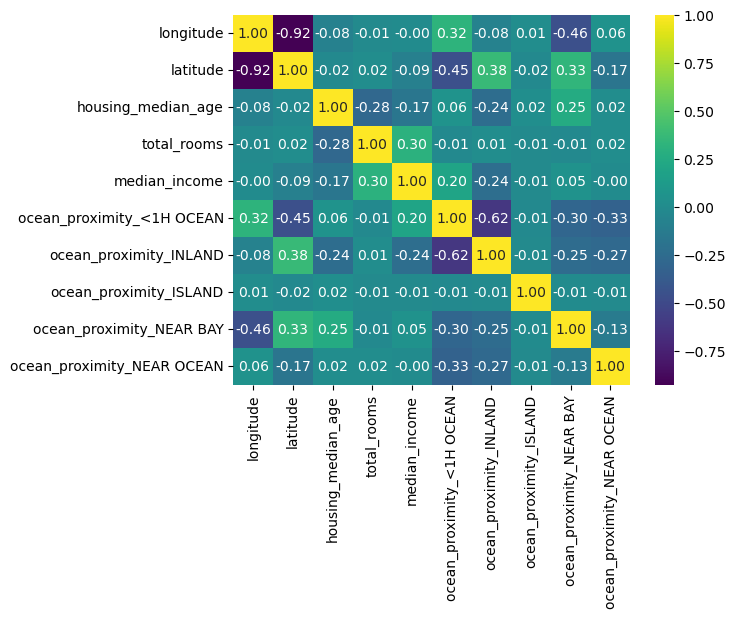

In [22]:
sns.heatmap(data=X.corr(), annot=True, cmap='viridis', fmt=".2f");

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print(X_train.shape, X_test.shape)

(13430, 10) (3358, 10)


<div style="text-align: center; background-color: #f2f2f2; padding: 10px;">
  <h1 style="color: #fabf81; font-size: 25px;">Machine Learning</h1>
</div>

In [24]:
def plot_cross_model(models, X_train, y_train, n_splits, scoring):
    
    fig, ax = plt.subplots()
    
    for model in models:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=12)

        results = cross_val_score(model, X=X_train, y=y_train, cv=kf, scoring=scoring)

        ax.plot(np.arange(0, n_splits), results, label=model.__class__.__name__)
        ax.legend()
    
    plt.show()

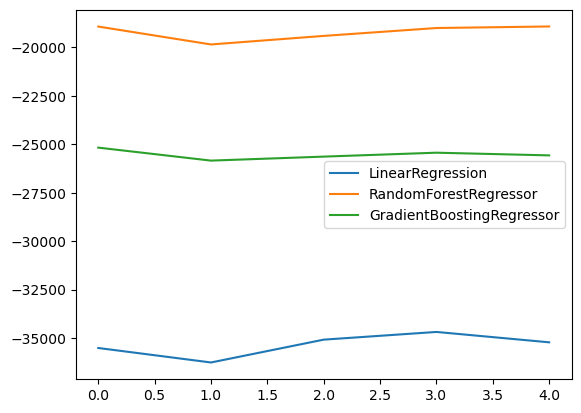

In [25]:
models = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

plot_cross_model(models, X_train, y_train, 5, 'neg_median_absolute_error')

- o modelo com melhor MAE foi RandomForestRegressor

### GridSearchCV

- Usando GridSearchCV para criar o melhor modelo RandomForest para prever os dados de teste

In [26]:
params = {
    'n_estimators' : [70, 90, 110],
    'criterion': ['squared_error'],
    'max_features': ['sqrt', 'log2']
}

In [27]:
reg_model = RandomForestRegressor()

In [28]:
grid = GridSearchCV(reg_model, param_grid=params, scoring='neg_median_absolute_error')

In [29]:
grid.fit(X_train, y_train)

grid.best_params_

{'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 90}

In [30]:
best_model = grid.best_estimator_

In [31]:
# usando o melhor modelo para prever os dados de teste

y_pred = best_model.predict(X_test)

In [32]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}\nMSE: {mean_squared_error(y_test, y_pred)}')

MAE: 29380.56669313745
MSE: 1875601155.7658567


In [33]:
# comparando alguns dos valores previstos pelo modelo

for i in range(50, 60):
    print(f'({i}) Valor Real -> {y_test.values[i]:.0f} ----- Valor Predito -> {y_pred[i]:.0f}\n')

(50) Valor Real -> 65400 ----- Valor Predito -> 82173

(51) Valor Real -> 263800 ----- Valor Predito -> 262602

(52) Valor Real -> 99200 ----- Valor Predito -> 109048

(53) Valor Real -> 109900 ----- Valor Predito -> 128753

(54) Valor Real -> 75900 ----- Valor Predito -> 106950

(55) Valor Real -> 145000 ----- Valor Predito -> 149626

(56) Valor Real -> 100000 ----- Valor Predito -> 118497

(57) Valor Real -> 161400 ----- Valor Predito -> 212913

(58) Valor Real -> 191800 ----- Valor Predito -> 201321

(59) Valor Real -> 233900 ----- Valor Predito -> 233637

